In [2]:
import networkx as nx
import numpy as np
from NEMtropy import UndirectedGraph, DirectedGraph
from tqdm import tqdm

In [3]:
yearlist = np.arange(1992, 2003)
yearlist

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002])

In [4]:
glist = []
reclist = []
Uclustlist = []
Dclustlist = []
Uassorlist = []
Dassorlist_i = []
Dassorlist_o = []
Dassorlist_io = []

for year in tqdm(yearlist):
    G = nx.read_graphml(f"data/World_Trade_Web/WDN_{year}.txt.graphml")
    glist.append(G)
    reclist.append(nx.reciprocity(G))
    Uclustlist.append(nx.average_clustering(G.to_undirected()))
    Dclustlist.append(nx.average_clustering(G))
    Uassorlist.append(nx.degree_pearson_correlation_coefficient(G.to_undirected(), weight='weight'))
    Dassorlist_i.append(nx.degree_pearson_correlation_coefficient(G, 'in', 'in', 'weight'))
    Dassorlist_o.append(nx.degree_pearson_correlation_coefficient(G, 'out', 'out', 'weight'))
    Dassorlist_io.append(nx.degree_pearson_correlation_coefficient(G, 'in', 'out', 'weight'))

100%|███████████████████████████████████████████| 11/11 [00:24<00:00,  2.22s/it]


In [7]:
def DB_analyze(G, nsamp=10):
    adj = nx.to_numpy_array(G)
    graph_D = DirectedGraph(adj)
    graph_D.solve_tool(model="dcm_exp", method="newton", initial_guess='random')
    
    graph_D.ensemble_sampler(nsamp, output_dir='sample_DB/')
    
    clustlist = []
    reclist = []
    for i in range(nsamp):
        edgelist_ens = np.loadtxt(f"sample_DB/{i}.txt")
        net = nx.DiGraph()
        net.add_edges_from(edgelist_ens)
        clustlist.append(nx.average_clustering(net))
        reclist.append(nx.reciprocity(G))
        
    return np.mean(clustlist), np.mean(reclist)
        
def UB_analyze(G, nsamp=10):
    adj = nx.to_numpy_array(G)
    adj_sym = adj + np.transpose(adj)
    graph_U = UndirectedGraph(adj_sym)
    graph_U.solve_tool(model='cm_exp', method='newton', initial_guess='random')
    
    graph_U.ensemble_sampler(nsamp, output_dir='sample_UB/')
    
    clustlist = []
    for i in range(nsamp):
        edgelist_ens = np.loadtxt(f"sample_UB/{i}.txt")
        net = nx.DiGraph()
        net.add_edges_from(edgelist_ens)
        clustlist.append(nx.average_clustering(net))
        
    return np.mean(clustlist)

In [8]:
from NEMtropy.network_functions import build_adjacency_from_edgelist

def DW_analyze(G, nsamp=10):
    adj = nx.to_numpy_array(G)
    graph_D = DirectedGraph(adj)
    graph_D.solve_tool(model='crema', method='newton', initial_guess='random',
                      max_steps=100000, adjacency='dcm_exp', method_adjacency='newton')
    
    graph_D.ensemble_sampler(nsamp, output_dir='sample_DW/')
    
    print(f"relative error on degree {graph_D.relative_error_degree}")
    print(f"relative error on strength {graph_D.relative_error_strength}")
    
    asslist_i = []
    asslist_o = []
    asslist_io = []
    for i in range(nsamp):
        edgelist_ens = np.loadtxt(f"sample_DW/{i}.txt")
        
        ens_adj = build_adjacency_from_edgelist(edgelist = edgelist_ens,
                                        is_directed = True,
                                        is_sparse = False,
                                        is_weighted = True)
        net = nx.from_numpy_array(ens_adj)
        asslist_i.append(nx.degree_pearson_correlation_coefficient(net, 'in', 'in', 'weight'))
        asslist_io.append(nx.degree_pearson_correlation_coefficient(net, 'in', 'out', 'weight'))
        asslist_o.append(nx.degree_pearson_correlation_coefficient(net, 'out', 'out', 'weight'))
        
    return np.mean(asslist_i), np.mean(asslist_o), np.mean(asslist_io)
    
def UW_analyze(G, nsamp=10):
    adj = nx.to_numpy_array(G)
    adj_sym = adj + np.transpose(adj)
    graph_U = UndirectedGraph(adj_sym)
    graph_U.solve_tool(model='crema', method='newton', initial_guess='random',
                      max_steps=100000, adjacency='cm_exp', method_adjacency='newton')
    
    graph_U.ensemble_sampler(nsamp, output_dir='sample_UW/')
    
    print(f"relative error on degree {graph_U.relative_error_degree}")
    print(f"relative error on strength {graph_U.relative_error_strength}")
    
    asslist = []
    for i in range(nsamp):
        edgelist_ens = np.loadtxt(f"sample_UW/{i}.txt")
        
        ens_adj = build_adjacency_from_edgelist(edgelist = edgelist_ens,
                                        is_directed = False,
                                        is_sparse = False,
                                        is_weighted = True)
        net = nx.from_numpy_array(ens_adj)
        
        asslist.append(nx.degree_pearson_correlation_coefficient(net, weight='weight'))
        
    return np.mean(asslist)

In [9]:
DBclust = []
Brec = []
UBclust = []
DWass_i = []
DWass_o = []
DWass_io = []
UWass = []

for G in tqdm(glist):
    DBclust_samp, Brec_samp = DB_analyze(G)
    DBclust.append(DBclust_samp)
    Brec.append(Brec_samp)
    
    UBclust.append(UB_analyze(G))
    
    DWass_i_samp, DWass_o_samp, DWass_io_samp = DW_analyze(G)
    DWass_i.append(DWass_i_samp)
    DWass_o.append(DWass_o_samp)
    DWass_io.append(DWass_io_samp)
    
    UWass.append(UW_analyze(G))

  0%|                                                    | 0/11 [00:00<?, ?it/s]/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:3181: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:3182: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 1.321097897744039e-09


/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:461: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:462: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]



solution error = 7.749264341327944e-09


/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:4515: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:4516: NumbaExperimentalFeatureWarning: First-class 


solution error = 337716.6877441406
relative error on degree 3.670364012720029e-11
relative error on strength 1.4289323166639217e-06


/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:1554: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/home/carlo/anaconda3/lib/python3.8/site-packages/NEMtropy/models_functions.py:1555: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warn


solution error = 4.518388704396784
relative error on degree 5.613387532577008e-11
relative error on strength 1.2871721467138297e-06


  9%|████                                        | 1/11 [00:35<05:57, 35.74s/it]


solution error = 5.407173375715502e-09


/home/carlo/anaconda3/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 5.526146651391173e-09

solution error = 128274.93920898438
relative error on degree 2.427945581210359e-10
relative error on strength 0.0016815894956316493

solution error = 21.82696990855038
relative error on degree 5.468562976189291e-11
relative error on strength 1.5317673855382054e-06


 18%|████████                                    | 2/11 [01:06<04:55, 32.84s/it]


solution error = 2.164171064578113e-09

solution error = 3.908382950612577e-09

solution error = 127697.61108398438
relative error on degree 7.327040561579321e-11
relative error on strength 4.2332747023777464e-07

solution error = 0.16987245623022318
relative error on degree 8.049840159531283e-11
relative error on strength 2.4057298258774042e-08


 27%|████████████                                | 3/11 [01:42<04:35, 34.44s/it]


solution error = 3.5568668010910187e-09

solution error = 1.5963621535775019e-09

solution error = 114193.56439208984
relative error on degree 1.8521223202459743e-10
relative error on strength 0.0011513330135007414

solution error = 488.6890812218189
relative error on degree 2.3527085042068004e-11
relative error on strength 1.0706913317697843e-05


 36%|████████████████                            | 4/11 [02:26<04:25, 37.98s/it]


solution error = 2.0547297197026637e-09

solution error = 2.029167944783694e-09

solution error = 107513.63934326172
relative error on degree 1.0590781585051446e-10
relative error on strength 0.00013897493231313375

solution error = 383.4201544523239
relative error on degree 4.056246247976312e-11
relative error on strength 9.620661848483742e-07


 45%|████████████████████                        | 5/11 [03:12<04:06, 41.12s/it]


solution error = 1.92545712707215e-09

solution error = 1.1764313967432827e-09

solution error = 97789.20123291016
relative error on degree 5.6975132430899843e-11
relative error on strength 0.0003595129836395908

solution error = 126.97394162602723
relative error on degree 2.5360691324749495e-11
relative error on strength 7.596448274174105e-06


 55%|████████████████████████                    | 6/11 [04:02<03:40, 44.08s/it]


solution error = 3.4588936159707373e-09

solution error = 1.299497398576932e-09

solution error = 314136.78326416016
relative error on degree 7.121309303565121e-11
relative error on strength 0.0003211484636275996

solution error = 38.15105362609029
relative error on degree 8.354624366955378e-11
relative error on strength 2.3994951341337524e-06


 64%|████████████████████████████                | 7/11 [04:52<03:03, 45.75s/it]


solution error = 2.379636043770006e-09

solution error = 1.0958842722175177e-09

solution error = 203190.64239501953
relative error on degree 9.666030938622801e-11
relative error on strength 5.011404994940541e-05

solution error = 6061.089232631028
relative error on degree 1.527946023673264e-11
relative error on strength 0.00011109940254350332


 73%|████████████████████████████████            | 8/11 [05:46<02:25, 48.41s/it]


solution error = 4.170264134017998e-09

solution error = 1.5952821286191465e-09

solution error = 146470.8162841797
relative error on degree 1.0984146925352434e-10
relative error on strength 1.640346703923907e-05

solution error = 946.5862387642264
relative error on degree 2.0811938838960486e-11
relative error on strength 4.761939021564897e-05


 82%|████████████████████████████████████        | 9/11 [06:39<01:39, 49.88s/it]


solution error = 3.346727339703648e-09

solution error = 7.307249916266301e-09

solution error = 212115.64794921875
relative error on degree 1.2165418431085646e-10
relative error on strength 3.6181870648749574e-07

solution error = 1437.240082345903
relative error on degree 3.079395123988084e-11
relative error on strength 3.842218819877445e-05


 91%|███████████████████████████████████████    | 10/11 [07:34<00:51, 51.43s/it]


solution error = 2.768544504760939e-09

solution error = 2.510432750568725e-09

solution error = 211617.81176757812
relative error on degree 1.8792378179903992e-10
relative error on strength 0.0004577134231303436

solution error = 286.79922776296735
relative error on degree 4.539799647318432e-11
relative error on strength 9.982135749231346e-06


100%|███████████████████████████████████████████| 11/11 [08:27<00:00, 46.17s/it]


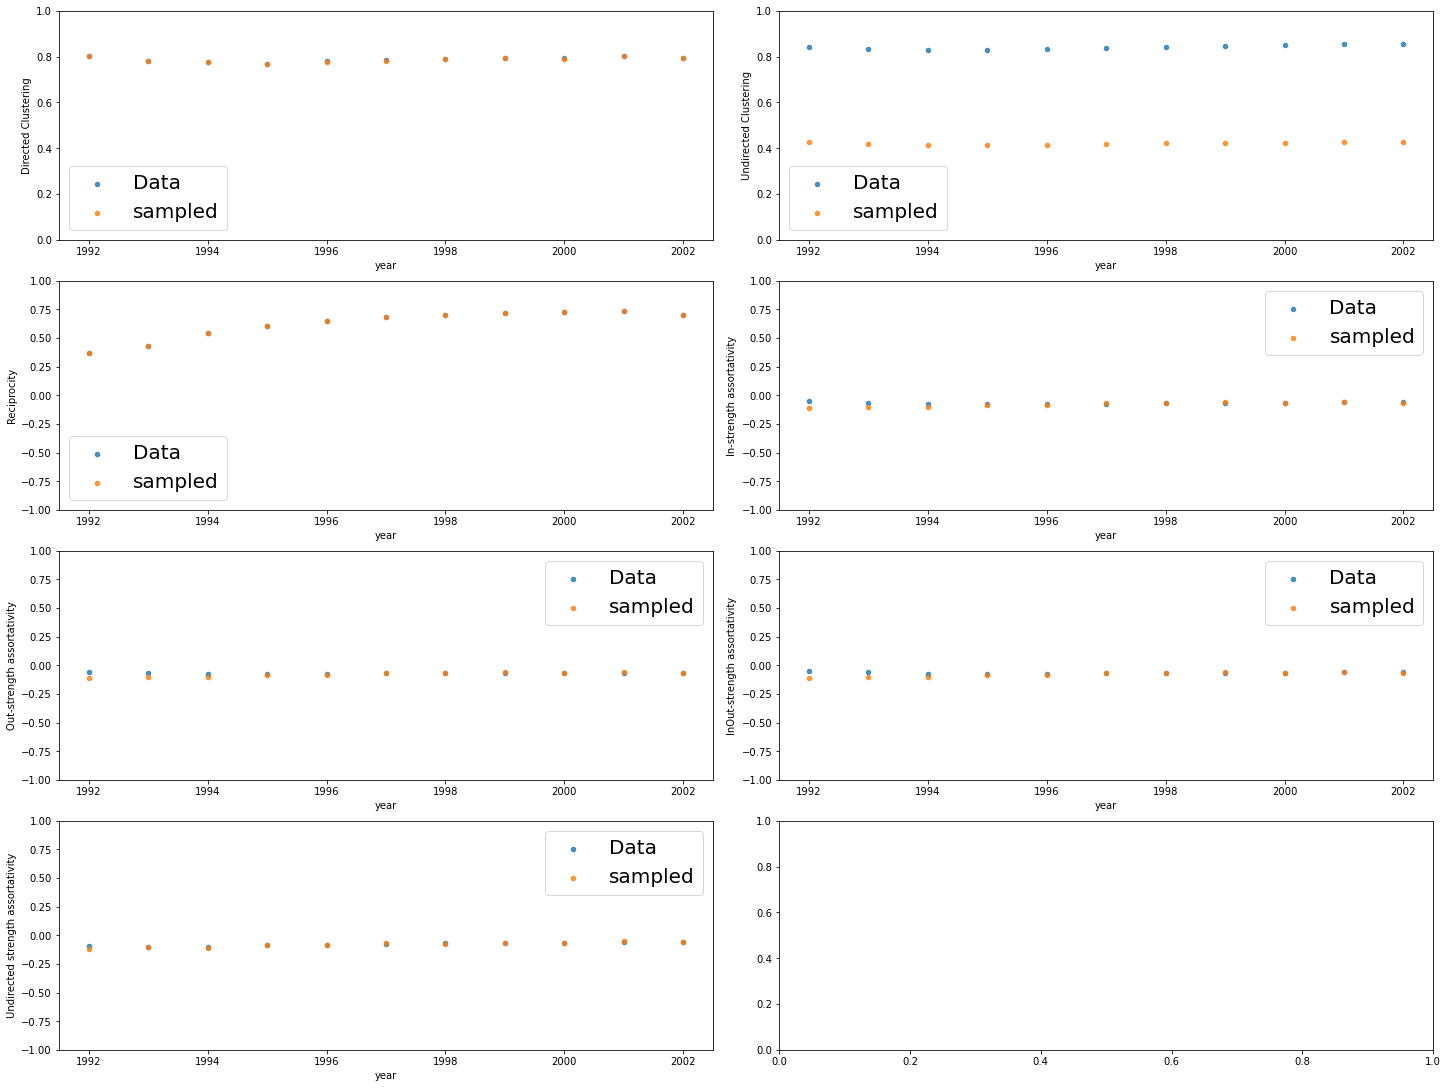

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, constrained_layout=True, figsize=(20,15))

axs[0,0].scatter(yearlist, Dclustlist, label="Data", s=20, alpha=0.8)
axs[0,0].scatter(yearlist, DBclust, label='sampled', s=20, alpha=0.8)
axs[0,0].set_xlabel("year")
axs[0,0].set_ylabel("Directed Clustering")
axs[0,0].set_ylim((0,1))
legend = axs[0,0].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

axs[0,1].scatter(yearlist, Uclustlist, label="Data", s=20, alpha=0.8)
axs[0,1].scatter(yearlist, UBclust, label='sampled', s=20, alpha=0.8)
axs[0,1].set_xlabel("year")
axs[0,1].set_ylabel("Undirected Clustering")
axs[0,1].set_ylim((0,1))
legend = axs[0,1].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

axs[1,0].scatter(yearlist, reclist, label="Data", s=20, alpha=0.8)
axs[1,0].scatter(yearlist, Brec, label='sampled', s=20, alpha=0.8)
axs[1,0].set_xlabel("year")
axs[1,0].set_ylabel("Reciprocity")
axs[1,0].set_ylim((-1,1))
legend = axs[1,0].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

axs[1,1].scatter(yearlist, Dassorlist_i, label="Data", s=20, alpha=0.8)
axs[1,1].scatter(yearlist, DWass_i, label='sampled', s=20, alpha=0.8)
axs[1,1].set_xlabel("year")
axs[1,1].set_ylabel("In-strength assortativity")
axs[1,1].set_ylim((-1,1))
legend = axs[1,1].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

axs[2,0].scatter(yearlist, Dassorlist_o, label="Data", s=20, alpha=0.8)
axs[2,0].scatter(yearlist, DWass_o, label='sampled', s=20, alpha=0.8)
axs[2,0].set_xlabel("year")
axs[2,0].set_ylabel("Out-strength assortativity")
axs[2,0].set_ylim((-1,1))
legend = axs[2,0].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

axs[2,1].scatter(yearlist, Dassorlist_io, label="Data", s=20, alpha=0.8)
axs[2,1].scatter(yearlist, DWass_io, label='sampled', s=20, alpha=0.8)
axs[2,1].set_xlabel("year")
axs[2,1].set_ylabel("InOut-strength assortativity")
axs[2,1].set_ylim((-1,1))
legend = axs[2,1].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

axs[3,0].scatter(yearlist, Uassorlist, label="Data", s=20, alpha=0.8)
axs[3,0].scatter(yearlist, UWass, label="sampled", s=20, alpha=0.8)
axs[3,0].set_xlabel("year")
axs[3,0].set_ylabel("Undirected strength assortativity")
axs[3,0].set_ylim((-1,1))
legend = axs[3,0].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)